In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import re

In [6]:
import numpy as np
import tensorflow as tf

In [7]:
import time
from datetime import datetime, timedelta

## Load custom libraries

In [8]:
import config as cfg
from dataload import load_test_batch, load_data, load_batch
from preprocessing import signalProcessBatch

## Tensorflow setup

In [9]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [10]:
# Functions to initialize weights and biases
def weight_variable(shape, name):
    """Creates a variable of size shape with random small positive numbers"""
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial, name=name)


def bias_variable(shape, name):
    """Creates a variable of size shape with a constant small positive number"""
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial, name=name)

In [11]:
# Conv2d, max pooling, and dropout wrapper functions for simplicity
def conv2d(x, W, sx=1, sy=1, padding='VALID'):
    return tf.nn.conv2d(x, W,
                        strides=[1, sx, sy, 1],
                        padding=padding)


def max_pool_2d(x, kx=2, ky=2, padding='VALID'):
    return tf.nn.max_pool(x,
                          ksize=[1, kx, ky, 1],
                          strides=[1, kx, ky, 1],
                          padding=padding)


def dropout(x, d, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(x, d), lambda: x)

In [12]:
# Numpy functions in tensorflow
def tf_diff_axis(arr):
    """Equivalent of np.diff on final axis"""
    return arr[..., 1:] - arr[..., :-1]

## Build model

In [13]:
reset_tf()

# Model parameters
melspec_shape = (122, 116)                          # Shape of Mel spectrum data (t x f)
melspec_size = melspec_shape[0] * melspec_shape[1]
mfcc_shape = (122, 13)                              # Shape of MFCC data (t x mfcc)
mfcc_size = mfcc_shape[0] * mfcc_shape[1]
sf_size = 122                                       # Length of 1D feature arrays e.g. ZCR and RMSE

n_classes = len(cfg.NUM2LABEL)

batch_size = 128
silence_size = 4
num_iterations = 200
display_step = 10
checkpoint_step = 100

learning_rate = 5e-4
dropout_prob_value = 0.50                           # Dropout, probability to keep units

noise_factor_value = 0.1
noise_frac_value = 0.25

In [14]:
print "Total feature size:  {}".format(melspec_size + mfcc_size + sf_size)

Total feature size:  15860


In [15]:
# MODEL
def convSpeechModelF(x_mel_in, x_mfcc_in, x_zcr_in, x_rmse_in,
                     dropout_prob=None, is_training=False):
    """Model based on Thomas O'Malley's conv model"""

    # ======================================================
    # Setup the parameters for the model
    # ======================================================

    # Mel spectrogram input with 120 mel filter banks
    t_size = 122
    f_size = 116

    # Parameters for Conv layer 1 filter
    # ("Denoising" and basic feature extraction)
    filter_size_t_1 = 7
    filter_size_f_1 = 3
    filter_count_1 = 64
    filter_stride_t_1 = 1
    filter_stride_f_1 = 1

    # Parameters for Conv layer 2 filter
    # (Look for local patterns across frequency bands)
    filter_size_t_2 = 1
    filter_size_f_2 = 7
    filter_count_2 = 128
    filter_stride_t_2 = 1
    filter_stride_f_2 = 1

    # Parameters for Conv layer 3 filter
    # (Detecting phoneme-level features)
    filter_size_t_3 = 1
    filter_size_f_3 = 10
    filter_count_3 = 256
    filter_stride_t_3 = 1
    filter_stride_f_3 = 1

    # Parameters for Conv layer 4 filter
    # (Looking for connected components of a short keyword at different points in time)
    filter_size_t_4 = 7
    filter_size_f_4 = 1
    filter_count_4 = 512
    filter_stride_t_4 = 1
    filter_stride_f_4 = 1

    # Paramaters for FC layers
    fc_output_channels_1 = 256
    fc_output_channels_2 = cfg.N_CLASSES

    # Number of elements in the first FC layer
    fc_element_count = t_size * filter_count_4

    # ======================================================
    # Setup dictionaries containing weights and biases
    # ======================================================

    weights = {
        'wconv1': weight_variable([filter_size_t_1, filter_size_f_1, 1, filter_count_1], 'wconv1'),
        'wconv2': weight_variable([filter_size_t_2, filter_size_f_2, filter_count_1, filter_count_2], 'wconv2'),
        'wconv3': weight_variable([filter_size_t_3, filter_size_f_3, filter_count_2, filter_count_3], 'wconv3'),
        'wconv4': weight_variable([filter_size_t_4, filter_size_f_4, filter_count_3, filter_count_4], 'wconv4'),
        'wfc1': weight_variable([fc_element_count, fc_output_channels_1], 'wfc1'),
        'wfc2': weight_variable([fc_output_channels_1, fc_output_channels_2], 'wfc2'),
    }
    biases = {
        'bconv1': bias_variable([filter_count_1], 'bconv1'),
        'bconv2': bias_variable([filter_count_2], 'bconv2'),
        'bconv3': bias_variable([filter_count_3], 'bconv3'),
        'bconv4': bias_variable([filter_count_4], 'bconv4'),
        'bfc1': bias_variable([fc_output_channels_1], 'bfc1'),
        'bfc2': bias_variable([fc_output_channels_2], 'bfc2'),
    }

    # ======================================================
    # Model definition and calculations
    # ======================================================

    # Calculate deltaZCR and deltaRMSE (pad 0 at end)
    paddings = tf.constant([[0, 0], [0, 1]])
    x_zcr_delta = tf.pad(tf_diff_axis(x_zcr_in), paddings, 'CONSTANT')
    x_rmse_delta = tf.pad(tf_diff_axis(x_rmse_in), paddings, 'CONSTANT')

    # Reshape to [audio file number, time size, 1]
    x_zcr_in_rs = tf.reshape(x_zcr_in, [-1, t_size, 1])
    x_zcr_delta_rs = tf.reshape(x_zcr_delta, [-1, t_size, 1])
    x_rmse_in_rs = tf.reshape(x_rmse_in, [-1, t_size, 1])
    x_rmse_delta_rs = tf.reshape(x_rmse_delta, [-1, t_size, 1])

    # Stack together ZCR and RMSE features using tf.concat
    zr_stack = tf.concat([x_zcr_in_rs, x_zcr_delta_rs, x_rmse_in_rs, x_rmse_delta_rs], 2)

    # Stack with the mel spectrogram using tf.concat to make fingerprint
    x_fingerprint = tf.concat([zr_stack, x_mel_in], 2)

    # Normalize (L2) along the time axis
    x_fingerprint_norm = tf.nn.l2_normalize(x_fingerprint, 1, epsilon=1e-8)

    # Reshape input to [audio file number, time size, freq size + stacked features, channel]
    x_fingerprint_rs = tf.reshape(x_fingerprint_norm, [-1, t_size, f_size + 4, 1])

    # Layer 1: first Conv layer, BiasAdd and ReLU
    x_fingerprint_1 = tf.nn.relu(conv2d(x_fingerprint_rs, weights['wconv1'],
                                        sx=filter_stride_t_1,
                                        sy=filter_stride_f_1,
                                        padding='SAME') + biases['bconv1'])

    # Dropout 1:
    x_fingerprint_dropout_1 = dropout(x_fingerprint_1, dropout_prob, is_training)

    # Max pool 1:
    x_fingerprint_mp_1 = max_pool_2d(x_fingerprint_dropout_1,
                                     kx=1,
                                     ky=3,
                                     padding='SAME')

    # Layer 2: second Conv layer, BiasAdd and ReLU
    x_fingerprint_2 = tf.nn.relu(conv2d(x_fingerprint_mp_1, weights['wconv2'],
                                        sx=filter_stride_t_2,
                                        sy=filter_stride_f_2,
                                        padding='SAME') + biases['bconv2'])

    # Dropout 2:
    x_fingerprint_dropout_2 = dropout(x_fingerprint_2, dropout_prob, is_training)
    
    # Max pool 2:
    x_fingerprint_mp_2 = max_pool_2d(x_fingerprint_dropout_2,
                                     kx=1,
                                     ky=4,
                                     padding='SAME')
    
    # Layer 3: third Conv layer, BiasAdd and ReLU
    x_fingerprint_3 = tf.nn.relu(conv2d(x_fingerprint_mp_2, weights['wconv3'],
                                        sx=filter_stride_t_3,
                                        sy=filter_stride_f_3,
                                        padding='VALID') + biases['bconv3'])
    
    # Dropout 3:
    x_fingerprint_dropout_3 = dropout(x_fingerprint_3, dropout_prob, is_training)

    # Layer 4: fourth Conv layer, BiasAdd and ReLU
    x_fingerprint_4 = tf.nn.relu(conv2d(x_fingerprint_dropout_3, weights['wconv4'],
                                        sx=filter_stride_t_4,
                                        sy=filter_stride_f_4,
                                        padding='SAME') + biases['bconv4'])
    
    # Dropout 4:
    x_fingerprint_dropout_4 = dropout(x_fingerprint_4, dropout_prob, is_training)

    # Flatten layers
    x_fingerprint_4_rs = tf.reshape(x_fingerprint_dropout_4, [-1, fc_element_count])

    # Layer 5: first FC layer
    x_fingerprint_5 = tf.matmul(x_fingerprint_4_rs, weights['wfc1']) + biases['bfc1']

    # Dropout 5:
    x_fingerprint_dropout_5 = dropout(x_fingerprint_5, dropout_prob, is_training)

    # Layer 6: final FC layer
    x_fingerprint_output = tf.matmul(x_fingerprint_dropout_5, weights['wfc2']) + biases['bfc2']

    return x_fingerprint_output

In [16]:
# Placeholders for signals preprocessing inputs
X_data = tf.placeholder(tf.float32, [None, cfg.SAMRATE], name='X_data')

noise_factor = tf.placeholder(tf.float32, shape=(), name='noise_factor')
noise_frac = tf.placeholder(tf.float32, shape=(), name='noise_frac')

In [17]:
# Define the audio features
x_mfcc, x_mel, x_zcr, x_rmse = signalProcessBatch(X_data,
                                                  noise_factor=noise_factor,
                                                  noise_frac=noise_frac,
                                                  window=512,
                                                  maxamps=cfg.MAXAMPS, sr=cfg.SAMRATE,
                                                  num_mel_bins=116, num_mfccs=13)

In [18]:
x_mel.shape

TensorShape([Dimension(None), Dimension(122), Dimension(116)])

In [19]:
# Placeholder variables output (1-hot vectors of size n_classes)
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
y_true_class = tf.argmax(y_true, 1, name='y_true_class')

In [20]:
# Dropout keep probability and training flag
dropout_prob = tf.placeholder(tf.float32, shape=(), name='dropout_prob')
is_training = tf.placeholder(tf.bool, name="is_training")

In [21]:
# Prediction from model
y_pred = convSpeechModelF(x_mel, x_mfcc, x_zcr, x_rmse, dropout_prob=dropout_prob, is_training=is_training)

### Quick test on 2 files

In [21]:
X_data_values, X_filenames = load_test_batch(cfg.DATA_DIR, idx=10, batch_size=2, samples=cfg.SAMRATE)

In [22]:
X_filenames

['clip_f07c5d227.wav', 'clip_fb1d0cdb0.wav']

In [23]:
x_mfcc_val, x_mel_val, x_zcr_val, x_rmse_val = sess.run(
    [x_mfcc, x_mel, x_zcr, x_rmse],
    feed_dict={X_data: X_data_values,
               noise_factor: 0.1,
               noise_frac: 1.0})

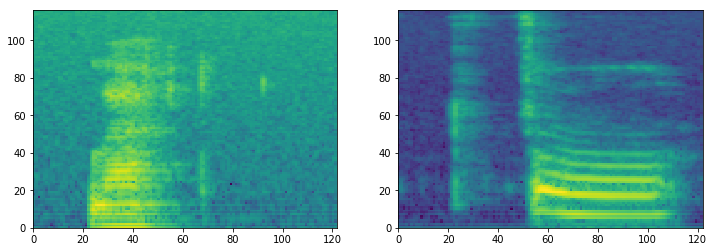

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.pcolormesh(x_mel_val[0].T)
plt.subplot(122)
plt.pcolormesh(x_mel_val[1].T);

In [25]:
# Initialize
reset_vars()

In [26]:
sess.run(y_pred, feed_dict={x_mel: x_mel_val,
                            x_mfcc: x_mfcc_val,
                            x_zcr: x_zcr_val,
                            x_rmse: x_rmse_val, 
                            dropout_prob: dropout_prob_value,
                            is_training: True})

array([[0.01721045, 0.01181257, 0.00685638, 0.02161178, 0.01324448,
        0.00580551, 0.00225295, 0.01711543, 0.01920522, 0.0203806 ,
        0.0005758 , 0.02192893],
       [0.00999058, 0.00506835, 0.00733013, 0.00740698, 0.0181094 ,
        0.008429  , 0.00834163, 0.01572766, 0.00567744, 0.01105481,
        0.01140607, 0.0098731 ]], dtype=float32)

### Loss, accuracy, etc.

In [22]:
# Cross entropy loss function with softmax then takes mean
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
tf.summary.scalar('loss', loss)

# Train and backprop gradients function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Evaluation and accuracy
y_pred_class = tf.argmax(y_pred, 1, name='y_pred_class')
correct_prediction = tf.equal(y_pred_class, y_true_class)
confusion_matrix = tf.confusion_matrix(y_true_class, y_pred_class, num_classes=n_classes)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [23]:
# Merge all summaries
merged = tf.summary.merge_all()

In [24]:
# Saver for checkpoints
saver = tf.train.Saver(tf.global_variables())

In [25]:
tf.global_variables()

[<tf.Variable 'wconv1:0' shape=(7, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'wconv2:0' shape=(1, 7, 64, 128) dtype=float32_ref>,
 <tf.Variable 'wconv3:0' shape=(1, 10, 128, 256) dtype=float32_ref>,
 <tf.Variable 'wconv4:0' shape=(7, 1, 256, 512) dtype=float32_ref>,
 <tf.Variable 'wfc1:0' shape=(62464, 256) dtype=float32_ref>,
 <tf.Variable 'wfc2:0' shape=(256, 12) dtype=float32_ref>,
 <tf.Variable 'bconv1:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bconv2:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'bconv3:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'bconv4:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'bfc1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'bfc2:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'wconv1/Adam:0' shape=(7, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'wconv1/Adam_1:0' shape=(7, 3, 1, 64) dtype=float32_ref>,
 <tf.Var

In [26]:
tf.trainable_variables()

[<tf.Variable 'wconv1:0' shape=(7, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'wconv2:0' shape=(1, 7, 64, 128) dtype=float32_ref>,
 <tf.Variable 'wconv3:0' shape=(1, 10, 128, 256) dtype=float32_ref>,
 <tf.Variable 'wconv4:0' shape=(7, 1, 256, 512) dtype=float32_ref>,
 <tf.Variable 'wfc1:0' shape=(62464, 256) dtype=float32_ref>,
 <tf.Variable 'wfc2:0' shape=(256, 12) dtype=float32_ref>,
 <tf.Variable 'bconv1:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bconv2:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'bconv3:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'bconv4:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'bfc1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'bfc2:0' shape=(12,) dtype=float32_ref>]

## Train model

In [27]:
# TRAINING
def run_optimize(num_iterations, logs_path, min_loss=0):
    # Start-time
    start_time = time.time()
    msg = "\n====================\nStarting training...\n===================="
    tf.logging.info(msg)
    
    df = load_data(cfg.DATA_DIR)

    w = 0.075
    tf.logging.info("Begin iterations...")
    for i in xrange(num_iterations):
        
        # Get the training batch
        X_train, y_true_batch = load_batch(df, cfg.DATA_DIR,
                                           batch_size=batch_size, silence_size=silence_size,
                                           label='train',
                                           random=True, seed=None,
                                           w=w, samples=cfg.SAMRATE)
        
        # Preprocess the training batch
        x_mfcc_batch, x_mel_batch, x_zcr_batch, x_rmse_batch = sess.run(
            [x_mfcc, x_mel, x_zcr, x_rmse],
            feed_dict={X_data: X_train,
                       noise_factor: noise_factor_value,
                       noise_frac: noise_frac_value})

        # Training optimization
        sess.run(optimizer, feed_dict={x_mel: x_mel_batch,
                                       x_mfcc: x_mfcc_batch,
                                       x_zcr: x_zcr_batch,
                                       x_rmse: x_rmse_batch, 
                                       y_true: y_true_batch,
                                       dropout_prob: dropout_prob_value,
                                       is_training: True})
        
        # Checkpoint save and validation step
        if ((i + 1) % checkpoint_step == 0) or (i == num_iterations - 1):
            
            # Checkpoint
            checkpoint_path = os.path.join(logs_path, 'model.ckpt')
            msg = "Saving checkpoint to: {}-{}"
            tf.logging.info(msg.format(checkpoint_path, i + 1))
            saver.save(sess, checkpoint_path, global_step=i + 1)
            
            # Load the validation batches
            val_batch_size = 100
            total_val_accuracy = 0
            total_conf_matrix = None
            set_size = 6700
            for j in xrange(0, set_size, val_batch_size):
                X_val, y_true_val = load_batch(df, cfg.DATA_DIR,
                                               batch_size=val_batch_size, silence_size=silence_size,
                                               label='val',
                                               random=False, seed=j,
                                               w=1.0, samples=cfg.SAMRATE)
    
                # Preprocess the validation batch
                x_mfcc_val, x_mel_val, x_zcr_val, x_rmse_val = sess.run(
                    [x_mfcc, x_mel, x_zcr, x_rmse],
                    feed_dict = {X_data: X_val,
                                 noise_factor: 0.0,
                                 noise_frac: 0.0})
                
                # Validation summary
                val_summary, loss_val, acc_val, conf_matrix = sess.run(
                    [merged, loss, accuracy, confusion_matrix],
                    feed_dict={x_mel: x_mel_val,
                               x_mfcc: x_mfcc_val,
                               x_zcr: x_zcr_val,
                               x_rmse: x_rmse_val,
                               y_true: y_true_val,
                               dropout_prob: 1.0,
                               is_training: False})
                total_val_accuracy += (acc_val * val_batch_size) / set_size
                if total_conf_matrix is None:
                    total_conf_matrix = conf_matrix
                else:
                    total_conf_matrix += conf_matrix
            
            msg = "Confusion Matrix:\n {}"
            tf.logging.info(msg.format(total_conf_matrix))
            msg = "VALIDATION ACC: {:6f}, (N = {})"
            tf.logging.info(msg.format(total_val_accuracy, set_size))

        # Display step
        if (i == 0) or ((i + 1) % display_step == 0) or (i == num_iterations - 1):
            # Training summary, loss and accuracy
            train_summary, loss_train, acc_train = sess.run(
                [merged, loss, accuracy],
                feed_dict={x_mel: x_mel_batch,
                           x_mfcc: x_mfcc_batch,
                           x_zcr: x_zcr_batch,
                           x_rmse: x_rmse_batch,
                           y_true: y_true_batch,
                           dropout_prob: 1.0,
                           is_training: False})
            train_writer.add_summary(train_summary, i + 1)
            
            # Display message
            msg = "  OPTIMIZE STEP: {:6d}, LOSS, {:.6f}, ACC: {:.6f}"
            tf.logging.info(msg.format(i + 1, loss_train, acc_train))
    
            # Check if loss is below minimum
            if loss_train < min_loss:
                break
    
    # End-time
    end_time = time.time()
    msg = "Time usage: {}"
    tf.logging.info(msg.format(timedelta(seconds=int(round(end_time - start_time)))))
    return

## Run Training (short test)

In [ ]:
# Initialize
reset_vars()

# Set path to summary logs
now = datetime.now()
logs_path = os.path.join(cfg.OUT_DIR, now.strftime("%Y%m%d-%H%M%S"), 'summaries')

# Create summary writers
train_writer = tf.summary.FileWriter(os.path.join(logs_path, 'train'), graph=tf.get_default_graph())
test_writer = tf.summary.FileWriter(os.path.join(logs_path, 'test'), graph=tf.get_default_graph())

In [ ]:
run_optimize(num_iterations, logs_path, min_loss=0)

INFO:tensorflow:
Starting training...
INFO:tensorflow:Begin iterations...
INFO:tensorflow:  OPTIMIZE STEP:      1, LOSS, 2.469336, ACC: 0.101562
